In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mesh import create_2d_circle, create_toy_mesh
from discretization import create_discretization_element, create_discretization_mesh
from solver import BVP_Poisson_solver

import warnings
warnings.filterwarnings('ignore')

## Poisson Problem

### One element

### Square

In [12]:
V_x = np.array([-1, 1, 1, -1])
V_y = np.array([-1, -1, 1, 1])
EtoV = np.array([[1, 2, 4], [2, 3, 4]]) - 1
mesh_square = create_toy_mesh(V_x, V_y, EtoV)

N = 12
discretization_element_square = create_discretization_element(N = N)
discretization_mesh_square = create_discretization_mesh(mesh = mesh_square, discretization_element = discretization_element_square)

### test 1 - chat
def u_exact(x, y): return np.sin(np.pi*x)*np.sin(np.pi*y)
def f_rhs(x, y): return 2*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)

bvp_poisson_solver = BVP_Poisson_solver(
    mesh = mesh_square,
    discretization_element = discretization_element_square,
    discretization_mesh = discretization_mesh_square,
    f_rhs = f_rhs,
    g_bc = u_exact
)

bvp_poisson_solver.solve()

100%|██████████| 2/2 [00:00<00:00, 60.09it/s]


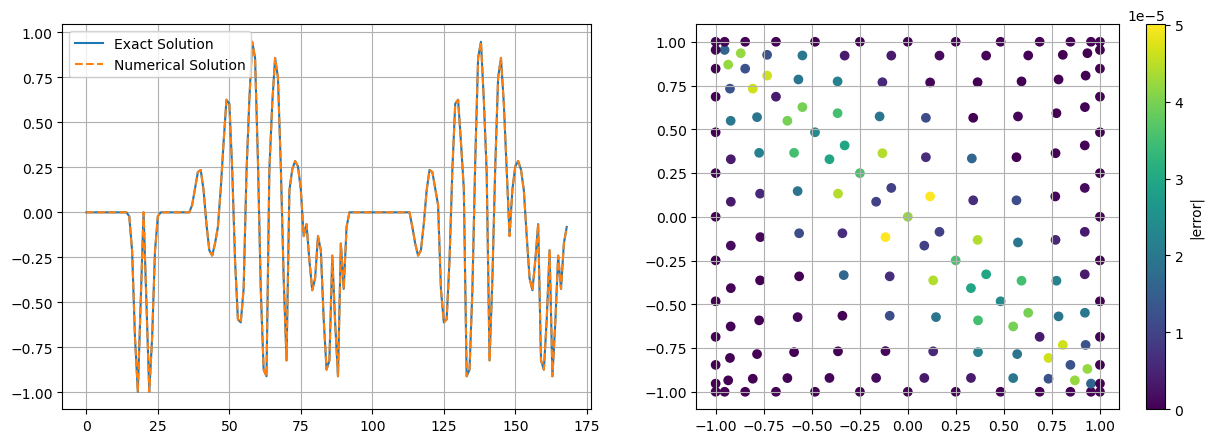

In [13]:
u_N = bvp_poisson_solver.u_N
x_global, y_global = discretization_mesh_toy.x_global, discretization_mesh_toy.y_global

u_true = u_exact(x_global, y_global)
e = u_N - u_true

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(u_true, label="Exact Solution")
ax[0].plot(u_N, label="Numerical Solution", linestyle='--')
ax[0].legend();
ax[0].grid();

sc = ax[1].scatter(x_global, y_global, c=np.abs(e), cmap='viridis')
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].grid();

### Circle

In [14]:
mesh2 = create_2d_circle(
    radius=1.0,
    origin=(0.0, 0.0),
    mesh_size=1
)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Done meshing 1D (Wall 9.7583e-05s, CPU 7.3e-05s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00438588s, CPU 0.004375s)
Info    : 72 nodes 143 elements


In [21]:
N = 10
discretization_element_2 = create_discretization_element(N = N)
discretization_mesh_2 = create_discretization_mesh(mesh = mesh2, discretization_element = discretization_element_2)

### test 1 - chat
def u_exact(x, y): return np.sin(np.pi*x)*np.sin(np.pi*y)
def f_rhs(x, y): return 2*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)

bvp_poisson_solver_2 = BVP_Poisson_solver(
    mesh = mesh2,
    discretization_element = discretization_element_2,
    discretization_mesh = discretization_mesh_2,
    f_rhs = f_rhs,
    g_bc = u_exact
)

bvp_poisson_solver_2.solve()

100%|██████████| 119/119 [00:01<00:00, 112.92it/s]


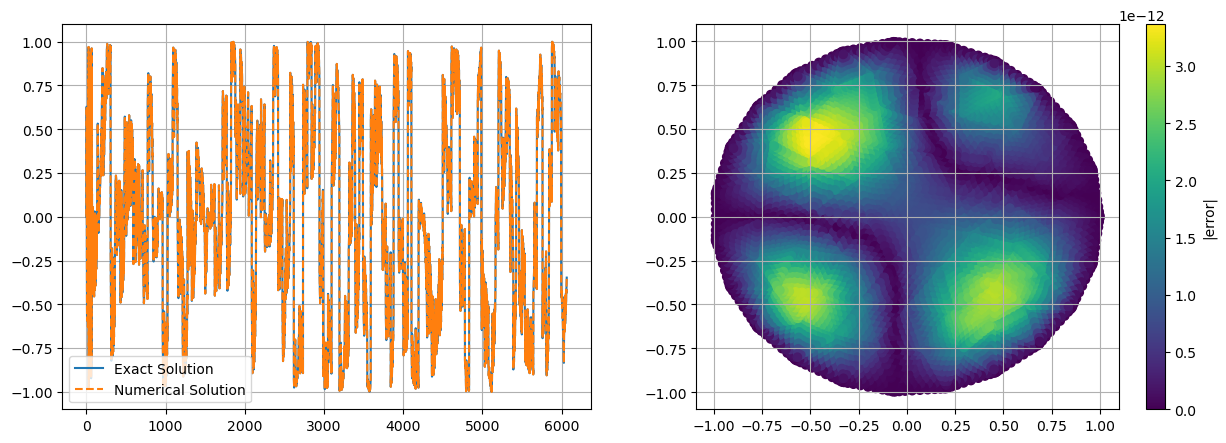

In [22]:
u_N = bvp_poisson_solver_2.u_N
x_global, y_global = discretization_mesh_2.x_global, discretization_mesh_2.y_global

u_true = u_exact(x_global, y_global)
e = u_N - u_true

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(u_true, label="Exact Solution")
ax[0].plot(u_N, label="Numerical Solution", linestyle='--')
ax[0].legend();
ax[0].grid();

sc = ax[1].scatter(x_global, y_global, c=np.abs(e), cmap='viridis')
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].grid();